# Performance Comparison of CNN model vs. Mobilenet_v2 pre-trained model

Problem/Main Objective: It takes time and resources to build a model from ground up. Therefore, implementing transfer learning by using a pretrained model to predict target outcomes can be better suited. In this project, a CNN model will be built and trained using Cifar10 dataset from ground up. Also, the pretrained model, Mobilenet_v2, will be used on Cifar10 dataset. The performances of each model will be computed and compared. The main objective of this project is to understand how performance differs among a model that is built from ground up vs. a pretrained model.

Dataset Used: The dataset used consists of images of 10 classes, including airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. The data is composed of 60000 images, 50000 for training and 10000 for testing. The images are 32x32x3 pixels. Data can be loaded direclty from Tensorflow or using the link: https://www.cs.toronto.edu/~kriz/cifar.html

Summary/Methods: The data is divided into train and test samples. The shape of the images in the data are analyzed to confirm the correct shape and size. The unique values of the target variable is checked to confirm their correspondence to each correct class. One hot encoding is used to convert unique values of the target to binary class matrix and feature variables are divided by 255 to normalize the data.

In [1]:
#Importing Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import seaborn as sns

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras import optimizers
import tensorflow as tf
import cv2 #to resize the data

import datetime
now = datetime.datetime.now

In [2]:
#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Importing the cifar10 datset and dividing into train and test models.
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

## Exploring the data and preprocessing

In [4]:
#Get the shapes of each test and train data.
print("X_train shape: ",X_train.shape)
print("X_test shape: ",X_test.shape)
print("\ny_train shape: ",y_train.shape)
print("y_test shape: ",y_test.shape)

X_train shape:  (50000, 32, 32, 3)
X_test shape:  (10000, 32, 32, 3)

y_train shape:  (50000, 1)
y_test shape:  (10000, 1)


In [5]:
#Decrease the dataset to work with due to insufficient processing power and space (RAM)
#Get the first 10000 rows for training and 2000 for testing
X_train=X_train[:10000]
X_test=X_test[:2000]

y_train=y_train[:10000] 
y_test=y_test[:2000]

Target variable has values from 0 to 9, corresponding to classes: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', respectively.



In [6]:
#Create an array that holds each class name
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
#Checking the frequency of classes in each target train and test data
unique, counts=np.unique(y_train, return_counts=True)
print("y_train class frequencies")
print(np.asarray((unique, counts)).T)

y_train class frequencies
[[   0 1005]
 [   1  974]
 [   2 1032]
 [   3 1016]
 [   4  999]
 [   5  937]
 [   6 1030]
 [   7 1001]
 [   8 1025]
 [   9  981]]


In [8]:
unique, counts=np.unique(y_test, return_counts=True)
print("y_test class frequencies")
print(np.asarray((unique, counts)).T)

y_test class frequencies
[[  0 196]
 [  1 198]
 [  2 195]
 [  3 199]
 [  4 198]
 [  5 185]
 [  6 216]
 [  7 193]
 [  8 217]
 [  9 203]]


The frequencies between each class in both train and test sets differ, however, differences is not more than 5% on train set and 8% on test set. This should not have a significant affect on the models performance.

In [9]:
#Lets prepare the dataset. There are 10 classes in total.
n_classes=10

#Convert the vectors to binary class matrix (one hot encoding)
y_train=to_categorical(y_train, n_classes)
y_test=to_categorical(y_test, n_classes)

In [10]:
#Confirm the shape of the target variables
print("y_train shape: ",y_train.shape)
print("y_test shape: ",y_test.shape)

y_train shape:  (10000, 10)
y_test shape:  (2000, 10)


In [11]:
#Set feature variables as float
X_train=X_train.astype("float32")
X_test=X_test.astype("float32")

In [12]:
#Normalize the data. Make sure the end values are between 0 and 1 to to feed into CNN.
X_train/=255
X_test/=255

In [13]:
#Confirming if data is normalized.
X_train[1,1,1]

array([0.5686275, 0.6      , 0.6039216], dtype=float32)

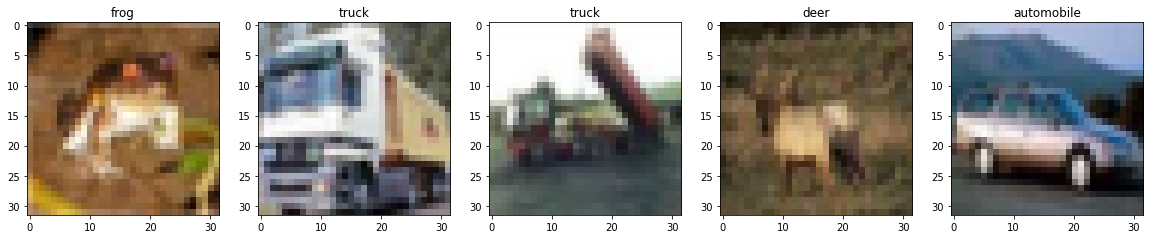

In [14]:
#Print first 5 image examples.
plt.figure(figsize=(20,5))
for image in range(5):
  plt.subplot(1,5,image+1)
  plt.imshow(X_train[image])
  plt.title(class_names[np.argmax(y_train[image])])
plt.show()

# Building Models

In [15]:
from IPython.core.pylabtools import figsize
# Function to evaluate models
model_acc=[]
def eval(model, X_train, X_test, y_train, y_test, epoch):
  opt=optimizers.Adam(lr=0.0005, decay=1e-6) #Using adam optimizer with learning rate 0.0005
  model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
  
  t=now() #Using to calculte time it takes to train the model
  hist=model.fit(X_train, y_train, batch_size=32, epochs=epoch, validation_data=(X_test, y_test),verbose=1, shuffle=True)
  score=model.evaluate(X_test, y_test, verbose=0)
  print("Loss: ",score[0])
  print("Accuracy: ",score[1])
  print('Training time: %s' % (now() - t))
  model_acc.append(score[1])
  return hist

# Function to Visualize the performance of the model
def vis(model_hist):
  plt.figure(figsize=(10,5))
 
  #Plotting loss
  plt.subplot(1,2,1)
  plt.plot(model_hist.history["loss"],'r', marker='.', label="Train Loss")
  plt.plot(model_hist.history["val_loss"],'b', marker='.', label="Validation Loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #Plotting accuracy
  plt.subplot(1,2,2)
  plt.plot(model_hist.history["accuracy"],'r', marker='.', label="Train Accuracy")
  plt.plot(model_hist.history["val_accuracy"],'b', marker='.', label="Validation Accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()


## Model 1: Basic CNN Model
Model 1 purpose is to asses how a basic cnn model will perform to examine how it can be improved.

Model contains following layers: Conv2D>Maxpooling2D>Flatten>Dense

In [16]:
#Set hyperparameters
filter=32
kernel=(3,3)
input_dim=(32,32,3) 

#Set Conv Layers
conv_layers=[
    Conv2D(filters=filter, kernel_size=kernel, padding='same', input_shape=input_dim),
    Activation('relu'),
    MaxPooling2D(),
    Flatten()
]

#Set classification layers
class_layers=[
    Dense(128, activation='relu'),
    Dense(n_classes, activation='softmax')#Final output is 10 because we have 10 classes.
]

In [17]:
#Combine the layers
model_1=Sequential(conv_layers+class_layers)
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

In [18]:
1#Evaluate Model_1

#Run the model with 20 epochs to examine change of performance with each epoch.
hist_model_1=eval(model_1, X_train, X_test, y_train, y_test, epoch=20) 

Epoch 1/20
313/313 [==============================] - 5s 6ms/step - loss: 1.8808 - accuracy: 0.3270 - val_loss: 1.6698 - val_accuracy: 0.4200
Epoch 2/20
313/313 [==============================] - 1s 4ms/step - loss: 1.5473 - accuracy: 0.4532 - val_loss: 1.5623 - val_accuracy: 0.4325
Epoch 3/20
313/313 [==============================] - 1s 4ms/step - loss: 1.3948 - accuracy: 0.5103 - val_loss: 1.4130 - val_accuracy: 0.4990
Epoch 4/20
313/313 [==============================] - 1s 4ms/step - loss: 1.2770 - accuracy: 0.5528 - val_loss: 1.3625 - val_accuracy: 0.5020
Epoch 5/20
313/313 [==============================] - 1s 4ms/step - loss: 1.1918 - accuracy: 0.5830 - val_loss: 1.3432 - val_accuracy: 0.5310
Epoch 6/20
313/313 [==============================] - 1s 4ms/step - loss: 1.1133 - accuracy: 0.6107 - val_loss: 1.2939 - val_accuracy: 0.5375
Epoch 7/20
313/313 [==============================] - 1s 4ms/step - loss: 1.0507 - accuracy: 0.6300 - val_loss: 1.2479 - val_accuracy: 0.5580
Epoch 

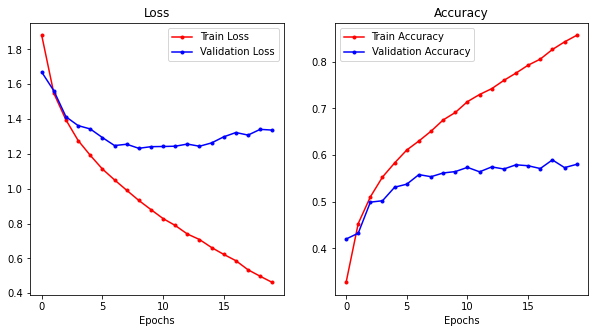

In [19]:
#Visualize the model_1 performance
vis(hist_model_1)

Model 1 takes 36 seconds to run with 20 epochs. After around 5 epochs, both loss and accuracy deviate from train and validation sets. Also, the model overfits where final train accuracy is much higher than and validation accuracy.


## Model 2 - Increasing Complexity
The purpose of Model 2 is to show the perfomance of the model with increase in complexity.

Model 2 consists of Conv2D->Conv2D->Maxpooling2D->Conv2D->Maxpooling2d->Flatten->Dense

In [20]:
#Building Model 2

#Add Conv Layers
conv_layers2=[
  Conv2D(filters=filter,kernel_size=kernel, padding='same',
                 input_shape=input_dim),
  Activation('relu'),

  Conv2D(filters=filter,kernel_size=kernel),
  Activation('relu'),
  MaxPooling2D(),

  Conv2D(64,kernel_size=kernel),  Activation('relu'),
  MaxPooling2D(),
  Flatten(),
  ]

#Set classification layers
class_layers2=[
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax') #Final output is 10 because we have 10 classes.   
]

In [21]:
#Analyzing model 2 layers and parameters
model_2=Sequential(conv_layers2+class_layers2)
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_2 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        18496     
                                                      

In [22]:
#Run Model 2 with 10 epochs, as accuracy highly differes with more than 10 epochs.
hist_model_2=eval(model_2, X_train, X_test, y_train, y_test, 10)

Epoch 1/10
313/313 [==============================] - 3s 6ms/step - loss: 1.7610 - accuracy: 0.3488 - val_loss: 1.5302 - val_accuracy: 0.4405
Epoch 2/10
313/313 [==============================] - 2s 5ms/step - loss: 1.4244 - accuracy: 0.4792 - val_loss: 1.3531 - val_accuracy: 0.5090
Epoch 3/10
313/313 [==============================] - 2s 5ms/step - loss: 1.2324 - accuracy: 0.5604 - val_loss: 1.2995 - val_accuracy: 0.5390
Epoch 4/10
313/313 [==============================] - 2s 5ms/step - loss: 1.0763 - accuracy: 0.6246 - val_loss: 1.1763 - val_accuracy: 0.5810
Epoch 5/10
313/313 [==============================] - 2s 5ms/step - loss: 0.9253 - accuracy: 0.6777 - val_loss: 1.2006 - val_accuracy: 0.5745
Epoch 6/10
313/313 [==============================] - 2s 5ms/step - loss: 0.7841 - accuracy: 0.7241 - val_loss: 1.1282 - val_accuracy: 0.6120
Epoch 7/10
313/313 [==============================] - 2s 5ms/step - loss: 0.6262 - accuracy: 0.7837 - val_loss: 1.1539 - val_accuracy: 0.6220
Epoch 

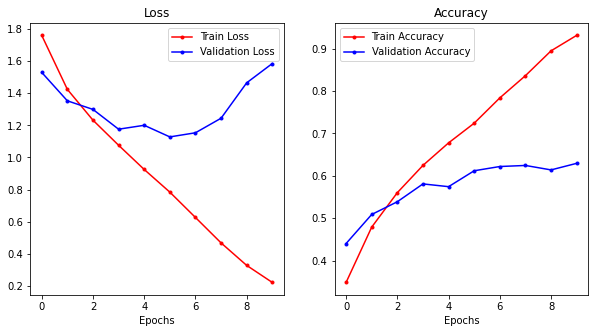

In [23]:
#Visualize the model_2 performance
vis(hist_model_2)

Increasing the complexity of the model improves model accuracy, however, model validation loss increases after 7 epochs. Also, validation accuracy of the model does not change after 5 epochs, though train accuracy does, showing overfitting. Lets fix this on the next model.

## Model 3 - Adding L2 Regularizaton, bias, and Dropout Layers to Reduce Overfitting

In an attempt to increase the performance and reduce overfitting, l2 regularizaton and dropout is added in classificaiton layer in Model 3. 

Model 3 consits of Conv2D->Conv2D->Maxpooling->Conv2D->Conv2D->Maxpooling->Flatten->Dense

In [24]:
#Add Conv Layers
conv_layers3=[
  Conv2D(filters=filter,kernel_size=kernel, padding='same',
                 input_shape=X_train.shape[1:], kernel_regularizer =tf.keras.regularizers.l2( l=0.001), use_bias=True),
  Activation('relu'),
  Conv2D(filters=filter,kernel_size=kernel, use_bias=True),
  Activation('relu'),
  MaxPooling2D(),

  Conv2D(64, (3, 3), padding='same', use_bias=True),
  Activation('relu'),
  Conv2D(64, (3, 3),kernel_regularizer =tf.keras.regularizers.l2( l=0.001), use_bias=True),
  Activation('relu'),
  MaxPooling2D(),
  Dropout(0.25),
  Flatten(),
  ]

#Set classification layers
class_layers3=[
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax') #Final output is 10 because we have 10 classes.   
]

In [25]:
#Check summary for model 3
model_3=Sequential(conv_layers3+class_layers3)
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_4 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_5 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 15, 15, 64)        18496     
                                                      

In [26]:
#Evaluate model 3 for 10 epochs
hist_model_3=eval(model_3, X_train, X_test, y_train, y_test, 10)

Epoch 1/10
313/313 [==============================] - 3s 7ms/step - loss: 2.0191 - accuracy: 0.2522 - val_loss: 1.7995 - val_accuracy: 0.3640
Epoch 2/10
313/313 [==============================] - 2s 6ms/step - loss: 1.6404 - accuracy: 0.3975 - val_loss: 1.4677 - val_accuracy: 0.5005
Epoch 3/10
313/313 [==============================] - 2s 6ms/step - loss: 1.4530 - accuracy: 0.4683 - val_loss: 1.4211 - val_accuracy: 0.4960
Epoch 4/10
313/313 [==============================] - 2s 6ms/step - loss: 1.3401 - accuracy: 0.5197 - val_loss: 1.2567 - val_accuracy: 0.5540
Epoch 5/10
313/313 [==============================] - 2s 6ms/step - loss: 1.2418 - accuracy: 0.5616 - val_loss: 1.2820 - val_accuracy: 0.5510
Epoch 6/10
313/313 [==============================] - 2s 6ms/step - loss: 1.1524 - accuracy: 0.5942 - val_loss: 1.1799 - val_accuracy: 0.5990
Epoch 7/10
313/313 [==============================] - 2s 6ms/step - loss: 1.0792 - accuracy: 0.6289 - val_loss: 1.1100 - val_accuracy: 0.6210
Epoch 

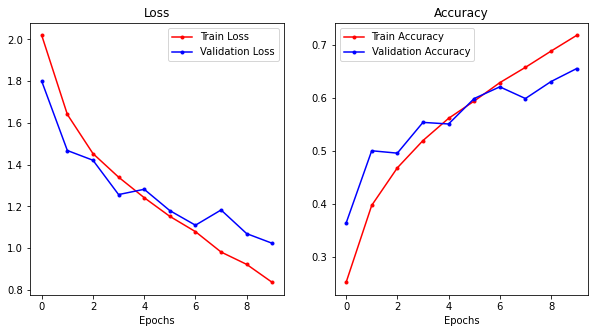

In [27]:
#Visualize the model_3 performance
vis(hist_model_3)

Adding extra Conv2D layer, L2 regularization, bias term, and dropout layers increased performance of the model and prevented overfitting, but there is still a little bit of overfitting left. To fix this, further techniques as image augmentation can be utalized. 

Based on the data, validation loss slows down around 10 epoch, and it really diviates from the train loss, so 10 epochs is good stopping point.

Model 3 performance is better than previous models, with only training time of 17s. This is a great improvement. Now lets compare how tranfer learning will perform in comparison. 

## Transfer Learning

Using the model, "tf2-preview/mobilenet_v2/classification" from Tensorflow Hub. This model is a pre-trained model for image classification tasks with an input size of 224x224 pixels. Therefore, the cifar10 dataset will be resized to 224x224 from 32x32 to fit the data into this pre-trained model.

In [28]:
#Import the necessary library to load the model
import tensorflow_hub as hub

#Load the pre-trained model and set the trainable='False' to freeze its weights. 
data_shape=(224,224) #Image shape used to train the pre-trained model.
pre_trained_model = tf.keras.Sequential([ 
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=data_shape+(3,), trainable=False)])

In [29]:
#Resize all training data into a new array

X_train_pretrained=[]

for i in range(len(X_train)):
  train_sized=cv2.resize(np.array(X_train[i]), data_shape)
  X_train_pretrained.append(train_sized)

In [30]:
#Resize the test data 
X_test_pretrained=[]

for j in range(len(X_test)):
  test_sized=cv2.resize(np.array(X_test[j]), data_shape)
  X_test_pretrained.append(test_sized)

In [31]:
#Turn X_test_pretrained and X_train_pretrained to an array
X_train_pretrained=np.array(X_train_pretrained)
X_test_pretrained=np.array(X_test_pretrained)

In [32]:
#Confirm their sizes
print(X_train_pretrained.shape)
print(X_test_pretrained.shape)

(10000, 224, 224, 3)
(2000, 224, 224, 3)


In [33]:
#Define final model
transfer_model=Sequential()
transfer_model.add(pre_trained_model) #Add the pre-trained model with trainable set to False
transfer_model.add(Dense(10, activation='softmax')) #Final output is 10 because we have 10 classes.


In [34]:
transfer_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 1001)              3540265   
                                                                 
 dense_9 (Dense)             (None, 10)                10020     
                                                                 
Total params: 3,550,285
Trainable params: 10,020
Non-trainable params: 3,540,265
_________________________________________________________________


In [35]:
hist_transfer_model=eval(transfer_model, X_train_pretrained, X_test_pretrained, y_train, y_test, 5)

Epoch 1/5
313/313 [==============================] - 21s 53ms/step - loss: 1.0122 - accuracy: 0.6686 - val_loss: 0.6657 - val_accuracy: 0.7730
Epoch 2/5
313/313 [==============================] - 15s 48ms/step - loss: 0.5579 - accuracy: 0.8097 - val_loss: 0.5954 - val_accuracy: 0.7965
Epoch 3/5
313/313 [==============================] - 15s 49ms/step - loss: 0.4895 - accuracy: 0.8334 - val_loss: 0.5666 - val_accuracy: 0.8045
Epoch 4/5
313/313 [==============================] - 15s 49ms/step - loss: 0.4473 - accuracy: 0.8433 - val_loss: 0.5406 - val_accuracy: 0.8205
Epoch 5/5
313/313 [==============================] - 15s 49ms/step - loss: 0.4241 - accuracy: 0.8522 - val_loss: 0.5487 - val_accuracy: 0.8135
Loss:  0.5487299561500549
Accuracy:  0.8134999871253967
Training time: 0:01:29.847449


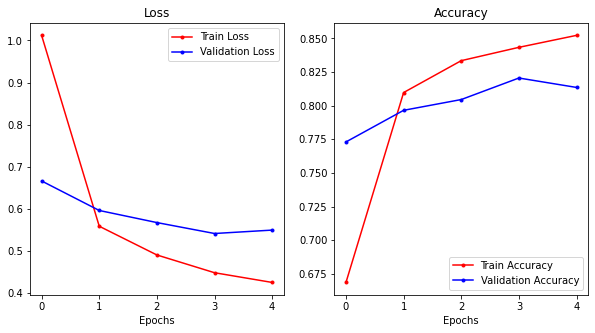

In [36]:
#Visualize performance of transfer model
vis(hist_transfer_model)

The performance of the transfer model is much higher than all the others but it does take longer to process, 90 seconds. This can be reduced by running the model only for 2 epochs, where the validation loss and accuracy begins to stagnate. 

In [37]:
# Graphing the final accuracies of the models
data_vis=pd.DataFrame({'Model':['Model 1','Model 2','Model 3','Transfer Model'], 
                       'Accuracy':[model_acc[0],model_acc[1],model_acc[2],model_acc[3]]})

In [38]:
data_vis

,Model,Accuracy
0,Model 1,0.5800
1,Model 2,0.6295
2,Model 3,0.6555
3,Transfer Model,0.8135


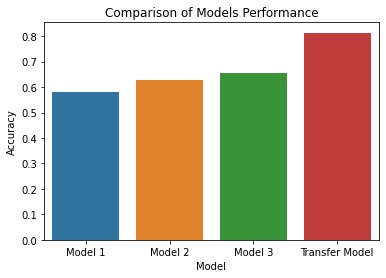

In [39]:
plt.title("Comparison of Models Performance")
ax = sns.barplot(x="Model", y="Accuracy", data=data_vis)

Results: Increasing the complexity of the model incrases the accuracy and decreases the number of epoch needed to run to achieve a good performance. For models that overfit, using regularization techniques, dropout, and bias term reduces overfitting. 

Which model to use? 
There is a trade-off between accuracy and processing time. If processing time is a concern for the client, model 3 might be better suited. However, because there is not a significant differences between processing times of Model 3 and Transfer Model, I would reccomend using Transfer Model due to its better performance.

Reccomendations/Suggestions: Data size used was not large enough to train these CNN models, even though data was availabe. The primary reason for the use of limited data was due to the computational insufficiency. Therefore, increasing RAM and memory will allow models to be trained on much higher data, which can increase performance. 

Other improvements can include using GridSearchCV to find best hyperparameters to increase predictive power, and data augmentation and early stopping techniques to better reduce overfitting. 
